#Set-up

In [ ]:
#Import libraries
!pip install yfinance
import yfinance as yf
import requests

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split

#Check for GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


###Get Raw Data

In [ ]:
ticker = 'AMD'
intvl = '1d'
start_date = "2000-01-01"
end_date = "2022-12-31"

In [ ]:
tick = yf.Ticker(ticker).history(start = start_date, end = end_date, interval = intvl)
df = pd.DataFrame(tick)

print(df.shape)
print(df.describe())


(5787, 7)
              Open         High          Low        Close        Volume  \
count  5787.000000  5787.000000  5787.000000  5787.000000  5.787000e+03   
mean     22.088134    22.566848    21.575293    22.072349  3.174962e+07   
std      27.908354    28.486900    27.276332    27.888764  3.194700e+07   
min       1.620000     1.690000     1.610000     1.620000  0.000000e+00   
25%       5.690000     5.830000     5.530000     5.695000  1.066600e+07   
50%      12.140000    12.360000    11.860000    12.120000  2.006610e+07   
75%      23.990000    24.600000    23.255000    23.920000  4.154105e+07   
max     163.279999   164.460007   156.100006   161.910004  3.250584e+08   

       Dividends  Stock Splits  
count     5787.0   5787.000000  
mean         0.0      0.000346  
std          0.0      0.026291  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0      2.000000  


In [ ]:
df.drop(['Open', 'High', 'Low', 'Volume', 'Dividends'], axis=1, inplace=True)

In [ ]:
print(df)

                               Close  Stock Splits
Date                                              
2000-01-03 00:00:00-05:00  15.500000           0.0
2000-01-04 00:00:00-05:00  14.625000           0.0
2000-01-05 00:00:00-05:00  15.000000           0.0
2000-01-06 00:00:00-05:00  16.000000           0.0
2000-01-07 00:00:00-05:00  16.250000           0.0
...                              ...           ...
2022-12-23 00:00:00-05:00  64.519997           0.0
2022-12-27 00:00:00-05:00  63.270000           0.0
2022-12-28 00:00:00-05:00  62.570000           0.0
2022-12-29 00:00:00-05:00  64.820000           0.0
2022-12-30 00:00:00-05:00  64.769997           0.0

[5787 rows x 2 columns]


In [ ]:
train_data = pd.DataFrame(df[['Close', 'Stock Splits']])

train_data.rename(columns={'Close':'close', 'Stock Splits':'stock_split'}, inplace=True)
train_data.head()

,close,stock_split
Date,,
2000-01-03 00:00:00-05:00,15.500,0.0
2000-01-04 00:00:00-05:00,14.625,0.0
2000-01-05 00:00:00-05:00,15.000,0.0
2000-01-06 00:00:00-05:00,16.000,0.0
2000-01-07 00:00:00-05:00,16.250,0.0


###Adjust for stock splits

In [ ]:
#Create column with cumulative product of all splits
train_data['cumulative_multiplier'] = train_data['stock_split'].replace(0.0, 1).cumprod()

#Add new column with adjusted price
train_data['adj_close'] = train_data['close'] * train_data['cumulative_multiplier']

print(train_data.head())
print(train_data.tail())

                            close  stock_split  cumulative_multiplier  \
Date                                                                    
2000-01-03 00:00:00-05:00  15.500          0.0                    1.0   
2000-01-04 00:00:00-05:00  14.625          0.0                    1.0   
2000-01-05 00:00:00-05:00  15.000          0.0                    1.0   
2000-01-06 00:00:00-05:00  16.000          0.0                    1.0   
2000-01-07 00:00:00-05:00  16.250          0.0                    1.0   

                           adj_close  
Date                                  
2000-01-03 00:00:00-05:00     15.500  
2000-01-04 00:00:00-05:00     14.625  
2000-01-05 00:00:00-05:00     15.000  
2000-01-06 00:00:00-05:00     16.000  
2000-01-07 00:00:00-05:00     16.250  
                               close  stock_split  cumulative_multiplier  \
Date                                                                       
2022-12-23 00:00:00-05:00  64.519997          0.0              

In [ ]:
train_data.drop(['close', 'stock_split', 'cumulative_multiplier'], axis=1, inplace=True)
train_data.head()

,adj_close
Date,
2000-01-03 00:00:00-05:00,15.500
2000-01-04 00:00:00-05:00,14.625
2000-01-05 00:00:00-05:00,15.000
2000-01-06 00:00:00-05:00,16.000
2000-01-07 00:00:00-05:00,16.250


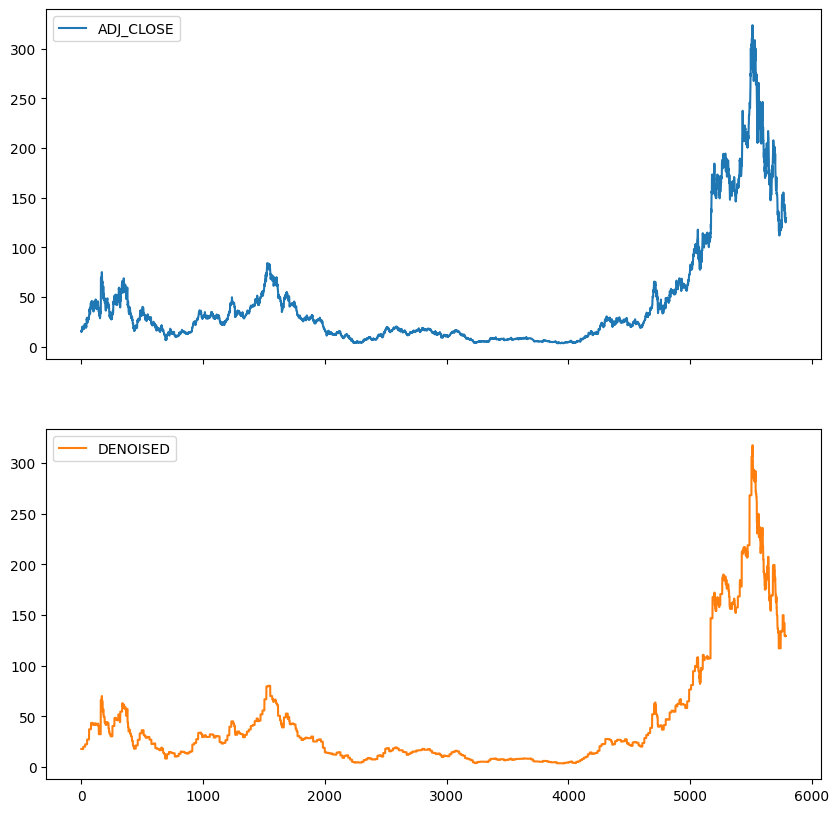

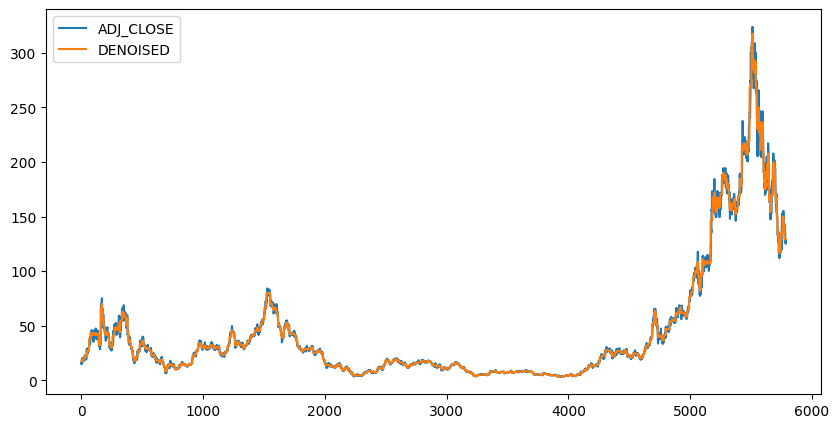

In [ ]:
import pywt
import copy

composite_signal =  train_data['adj_close'].values
def filter_bank(index_list, wavefunc='haar', lv=4, m=1, n=4, plot=False):

    # Decomposing
    coeff = pywt.wavedec(composite_signal,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0
    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold
    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])

    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]

    if plot:
        denoised_index = np.sum(coeff, axis=0)
        data = pd.DataFrame({'ADJ_CLOSE': index_list, 'DENOISED': denoised_index})
        train_data['denoised_adj_close'] = denoised_index #add new denoised_close column to train_data
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))

    return coeff

#plot results
coeff=filter_bank(composite_signal,plot=True)


In [ ]:
print(train_data.shape)
print(train_data.info())
train_data.head()

(5787, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5787 entries, 2000-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adj_close           5787 non-null   float64
 1   denoised_adj_close  5787 non-null   float64
dtypes: float64(2)
memory usage: 135.6 KB
None


,adj_close,denoised_adj_close
Date,,
2000-01-03 00:00:00-05:00,15.500,17.755859
2000-01-04 00:00:00-05:00,14.625,17.755859
2000-01-05 00:00:00-05:00,15.000,17.755859
2000-01-06 00:00:00-05:00,16.000,17.755859
2000-01-07 00:00:00-05:00,16.250,17.755859


In [ ]:
train_data.describe()

,adj_close,denoised_adj_close
count,5787.000000,5787.000000
mean,43.238022,43.237446
std,55.620436,55.514193
min,3.240000,3.567500
25%,11.390000,11.363267
50%,23.680000,23.740000
75%,44.632500,45.022500
max,323.820007,317.627526


In [ ]:
X = []
y = []

# for i in range (60, train_data.shape[0]):
#   X.append(train_data.iloc[i-60:i, 1])
#   y.append(train_data.iloc[i, 0])

# X, y = np.array(X), np.array(y)

# y=np.reshape(y, (len(y), 1))

for i in range (60, train_data.shape[0]):
  X.append(train_data.iloc[i-60:i, 1])
  y.append(train_data.iloc[i, 0])

X, y = np.array(X), np.array(y)

y=np.reshape(y, (len(y), 1))

In [ ]:
print(X.shape)
print(y.shape)
print(X)
print(y)

(5727, 60)
(5727, 1)
[[ 17.75585938  17.75585938  17.75585938 ...  27.10351563  27.10351563
   27.10351563]
 [ 17.75585938  17.75585938  17.75585938 ...  27.10351563  27.10351563
   27.10351563]
 [ 17.75585938  17.75585938  17.75585938 ...  27.10351563  27.10351563
   27.10351563]
 ...
 [134.23826752 134.23826752 134.23826752 ... 128.91724377 129.34624815
  129.34624815]
 [134.23826752 134.23826752 134.23826752 ... 129.34624815 129.34624815
  129.34624815]
 [134.23826752 134.23826752 117.10249901 ... 129.34624815 129.34624815
  129.34624815]]
[[ 27.375     ]
 [ 30.        ]
 [ 29.5       ]
 ...
 [125.13999939]
 [129.63999939]
 [129.53999329]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)
y = sc.fit_transform(y)

In [ ]:
train_size = round(X.shape[0] * .8)

X_train, X_test = X[:train_size], X[train_size-60:]
y_train, y_test = y[:train_size], y[train_size-60:]

print(train_size)

4582


In [ ]:
print(X_train.shape)
print(y_train.shape)
print("=============")
print(X_test.shape)
print(y_test.shape)
print("=============")
print(X.shape)
print(y.shape)

(4582, 60)
(4582, 1)
(1205, 60)
(1205, 1)
(5727, 60)
(5727, 1)


##Build and Train the Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras import optimizers
from keras import backend as K

regressor = Sequential()

#Include notes about why we use the RMSE instead of MSE
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
regressor.add(LSTM(units = 150, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [ ]:
# #Layer 2
# regressor.add(LSTM(units = 150, return_sequences = True))
# regressor.add(Dropout(0.2))

# #Layer 3
# regressor.add(LSTM(units = 150))
# regressor.add(Dropout(0.2))

In [ ]:
# regressor.add(Dense(units = 150, activation='relu'))

In [ ]:
regressor.add(Dense(units = 1))
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


##Compile and Fit model to training set

In [ ]:
regressor.compile(optimizer = 'adam', loss = root_mean_squared_error)

regressor.fit(X_train, y_train, epochs = 100, batch_size = 16)

Epoch 1/100
287/287 [==============================] - 5s 7ms/step - loss: 0.0067
Epoch 2/100
287/287 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 3/100
287/287 [==============================] - 2s 5ms/step - loss: 0.0043
Epoch 4/100
287/287 [==============================] - 1s 5ms/step - loss: 0.0043
Epoch 5/100
287/287 [==============================] - 2s 5ms/step - loss: 0.0042
Epoch 6/100
287/287 [==============================] - 2s 5ms/step - loss: 0.0042
Epoch 7/100
287/287 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/100
287/287 [==============================] - 3s 10ms/step - loss: 0.0038
Epoch 9/100
287/287 [==============================] - 2s 9ms/step - loss: 0.0039
Epoch 10/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0041
Epoch 11/100
287/287 [==============================] - 3s 9ms/step - loss: 0.0038
Epoch 12/100
287/287 [==============================] - 3s 12ms/step - loss: 0.0039
Epoch 13/1

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = regressor.predict(X_test)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
predictions = sc.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

38/38 [==============================] - 0s 3ms/step


123.04300325782494

(5787, 1)
(4582, 1)
(1205, 1)


<ipython-input-74-56a561249c1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['Predictions'] = predictions


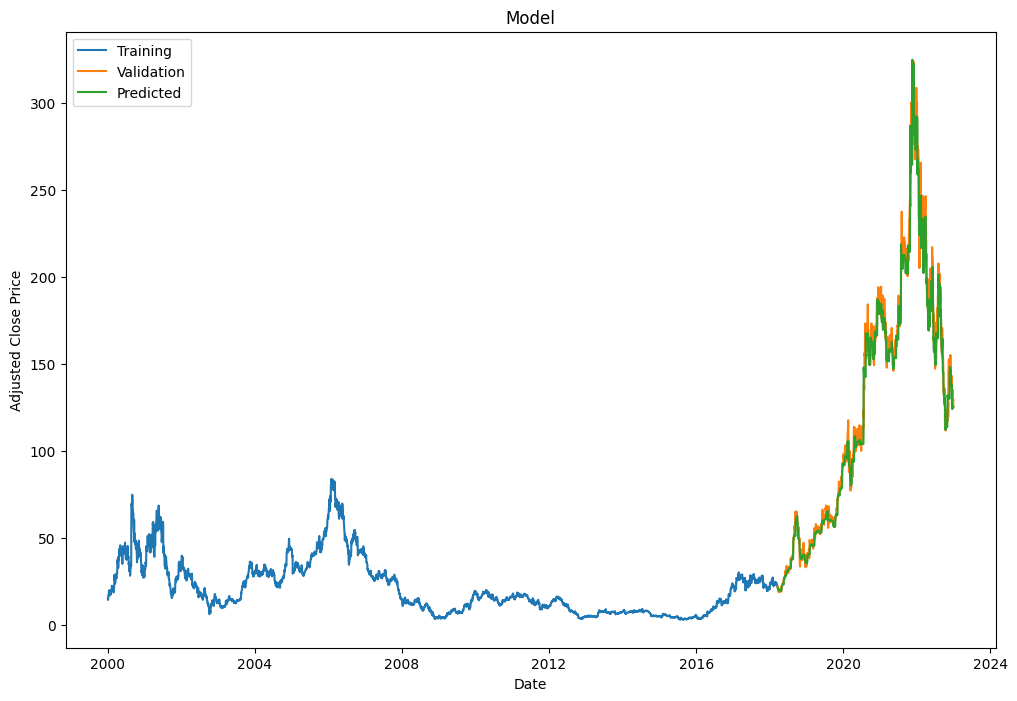

In [ ]:
real_adj_price = train_data.filter(['adj_close'])
print(real_adj_price.shape)
train = real_adj_price[:train_size]
validate = real_adj_price[train_size:]

print(train.shape)
print(validate.shape)

validate['Predictions'] = predictions
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(train)
plt.plot(validate[['adj_close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predicted'])
plt.show()